<a href="https://colab.research.google.com/github/lennonchaves/llm-fine-tuning-rag/blob/main/TPFinal_Lennon_Chaves_Etapa_Parte3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabalho Final de NLP**
**Disciplina:** Tópicos Especiais em Recuperação de Informação (TERI) - NLP

**Aluno:** Lennon Correa Chaves

**Matrícula:** 3240097

**Entregável:**
- Fine Tuning com LoRA


# Parte 3: Fine Tuning com LoRA

Instalação dos pacotes necessários para realização do fine-tuning utilizando a estratégia qlora

In [ ]:
!pip install datasets
!pip install -U "transformers==4.38.1" "datasets==2.17.0" "peft==0.8.2" "accelerate==0.27.1" "bitsandbytes==0.42.0" "trl==0.7.10"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
   

Login no huggingface

In [ ]:
from huggingface_hub import login

# Login no Hugging Face
HF_TOKEN = 'TOKEN'
login(token = HF_TOKEN)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Carregamento da base de dados sintética que será utilizada para o fine tuning.
- bases de treino, validação e teste criada

In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# Carregar a base de dados sintética
df = pd.read_csv('database_sintetica.csv')
df['input'] = df['pergunta'] + df['resposta']
df.drop(columns=['pergunta','resposta'], axis=1, inplace=True)

# Dividir os dados em treino, validação e teste
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Converter para datasets Hugging Face
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Criar um DatasetDict
datasets = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

print(datasets['train'].shape) # Dimensão Base Treino
print(datasets['validation'].shape) # Dimensão Base Validação
print(datasets['test'].shape) # Dimensão Base Teste

(800, 2)
(100, 2)
(100, 2)


Carregamento e configuração do modelo pré-treinado: gemma-7b-it - https://huggingface.co/google/gemma-7b-it


In [ ]:
import pandas as pd
import torch
from datasets import Dataset, load_dataset
from random import randrange
from peft import LoraConfig, get_peft_model, AutoPeftModelForCausalLM
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments, GemmaTokenizer, EarlyStoppingCallback
from trl import SFTTrainer
import numpy as np

# Definição do modelo que será utilizado durante o fine-tuning
model_id = "google/gemma-7b-it"

# Quantização de bits
compute_dtype = getattr(torch, "float16")

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    quantization_activation=True

)

# Load do tokenizador
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Load do modelo pré-treinado
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             quantization_config=bnb_config,
                                             device_map="auto",
                                             use_cache=False)

# Configuração da camada de Lora
max_length = 64

# Função de tokenização
def tokenize_function(examples):
    return tokenizer(examples["input"], truncation=True, padding="max_length", max_length=max_length)

# Aplicar a tokenização aos datasets
tokenized_datasets = datasets.map(tokenize_function, batched=True)

# Limpar a memória
torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Checagem do funcionamento da geração de texto do LLM antes do fine-tuning

- O código abaixo tokeniza um texto de pergunta sobre a legislação da UFAM, envia-o a um modelo de linguagem no dispositivo "cuda:0", gera uma resposta de até 200 novos tokens e decodifica e imprime a resposta gerada pelo modelo.

In [ ]:
# Texto de pergunta
text = "Suponha que voce é o um assistente especialista em responder perguntas sobre a legislação da Universidade Federal do Amazonas, Pergunta: Qual a instância responsável por estabelecer normas e regulamentos referentes ao ensino, pesquisa e extensão na Universidade Federal do Amazonas?"
device = "cuda:0"
# Enviar o texto para o modelo e gerar uma resposta
inputs = tokenizer(text, return_tensors="pt").to(device)
# Geração da resposta com base no prompt informado
outputs = model.generate(**inputs, max_new_tokens=200)
# Impressão da resposta gerada
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Suponha que voce é o um assistente especialista em responder perguntas sobre a legislação da Universidade Federal do Amazonas, Pergunta: Qual a instância responsável por estabelecer normas e regulamentos referentes ao ensino, pesquisa e extensão na Universidade Federal do Amazonas?

A resposta para a pergunta é: a rectora da Universidade Federal do Amazonas.

A rectora é a autoridade máxima de cada universidade federal, responsável por garantir a integralidade do ensino, pesquisa e extensão.


**Técnica LoRA (Low-Rank Adaptation)**

O código abaixo configura e executa um treinamento de modelo utilizando a técnica LoRA (Low-Rank Adaptation) com configurações específicas. Aqui estão as etapas com bullets:

Configuração LoRA:

- Define uma configuração LoRA com:
- Rank (r) de 8.
- Módulos alvo para adaptação: "q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj".
- Tipo de tarefa definido como "CAUSAL_LM".

Argumentos de Treinamento:

- Define os argumentos de treinamento com: 20 épocas de treinamento.
- Tamanho do lote de 10 para treinamento e 1 para avaliação.
- Passos de acumulação de gradiente definidos como 8 e checkpoint de gradiente ativado.
- Otimizador "adamw_hf".
- Estratégia de salvamento e avaliação por época.
- Taxa de aprendizado de 5e-5.
- Treinamento em ponto flutuante de 16 bits (fp16)ativado.
- Diretório de saída "gemma-tunned".
- Semente para reprodução definida como 42.
- Diretório de logs "./logs" com passos de logging a cada 10 iterações.
- Carregar o melhor modelo no final do treinamento.
Número de workers do DataLoader definido como 4 e

Callback de Early Stopping:

- Configura um callback de early stopping com:
- Paciência de 2 épocas sem melhoria.
- Limite mínimo de melhoria de 0.1.

Definição do Trainer:

- Instancia um SFTTrainer com o modelo especificado.
- Argumentos de treinamento definidos anteriormente.
- Conjunto de dados de treinamento e avaliação.
- Configuração LoRA aplicada.

In [ ]:
# Configuração LoRA
lora_config = LoraConfig(
    r = 8,
    target_modules = ["q_proj", "o_proj", "k_proj", "v_proj",
                      "gate_proj", "up_proj", "down_proj"],
    task_type = "CAUSAL_LM"
)

# Define os argumentos de treinamento. Para a lista completa de argumentos, verifique
# https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments
training_args = TrainingArguments(
    num_train_epochs=20,  # Número de épocas de treinamento
    per_device_train_batch_size=10,  # Tamanho do lote por dispositivo para treinamento
    per_device_eval_batch_size=1,  # Tamanho do lote por dispositivo para avaliação
    gradient_accumulation_steps=8,  # Passos de acumulação de gradiente
    gradient_checkpointing=True,  # Ativa checkpoint de gradiente
    optim="adamw_hf",  # Usa o AdamW padrão para mais eficiência
    save_strategy="epoch",  # Estratégia de salvamento por época
    learning_rate=5e-5,  # Taxa de aprendizado
    fp16=True,  # Treinamento em ponto flutuante de 16 bits
    output_dir="gemma-tunned",  # Diretório de saída
    seed=42,  # Semente para reprodução
    evaluation_strategy="epoch",  # Estratégia de avaliação por época
    logging_dir='./logs',  # Diretório para armazenar logs
    logging_steps=10,  # Passos de logging
    report_to="none",  # Desabilita relatórios para qualquer sistema
    load_best_model_at_end=True,  # Carrega o melhor modelo no final do treinamento
    dataloader_num_workers=4,  # Aumenta o número de workers do DataLoader
    dataloader_pin_memory=True  # Melhora a performance do DataLoader
)

# Instanciar o callback de early stopping
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2,  # Número de épocas sem melhoria antes de parar
    early_stopping_threshold=0.1  # Valor mínimo de melhoria para considerar uma época como melhor
)

# Libera o cache da memória CUDA
torch.cuda.empty_cache()

# Definindo o Trainer
trainer = SFTTrainer(
    model=model,  # Modelo a ser treinado
    args=training_args,  # Argumentos de treinamento definidos anteriormente
    train_dataset=tokenized_datasets["train"],  # Conjunto de dados de treinamento
    eval_dataset=tokenized_datasets["validation"],  # Conjunto de dados de avaliação
    dataset_text_field='input',  # Campo de texto do conjunto de dados
    callbacks=[early_stopping_callback],  # Adicionar o callback de early stopping
    peft_config=lora_config  # Configuração LoRA
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:223: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:290: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


Realização do treinamento do modelo para realização do fine-tuning:

In [ ]:
# Libera o cache da memória CUDA antes de treinar o modelo
torch.cuda.empty_cache()

# Treinando o modelo
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,10.920600,9.646540
2,8.692800,7.898113
3,6.950900,6.105240
4,5.041900,3.976598
5,2.931600,2.065086
6,1.874000,1.730797
7,1.558900,1.505391
8,1.341500,1.342526
9,1.157800,1.222494
10,1.008700,1.138775


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/lib/python3.10/multi

TrainOutput(global_step=110, training_loss=3.8514240004799585, metrics={'train_runtime': 866.9511, 'train_samples_per_second': 18.455, 'train_steps_per_second': 0.231, 'total_flos': 4.81696750261248e+16, 'train_loss': 3.8514240004799585, 'epoch': 11.0})

Avaliação do modelo no conjunto de validação:

In [ ]:
# Avaliar o modelo no conjunto de validação
eval_results = trainer.evaluate(eval_dataset=tokenized_datasets["validation"])
print(f"Resultados da validação: {eval_results}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Resultados da validação: {'eval_loss': 0.9148386120796204, 'eval_runtime': 14.5495, 'eval_samples_per_second': 6.873, 'eval_steps_per_second': 6.873, 'epoch': 11.0}


Avaliação do modelo no conjunto de testes:

In [ ]:
# Testar o modelo no conjunto de teste
test_results = trainer.evaluate(eval_dataset=tokenized_datasets["test"])
print(f"Resultados do teste: {test_results}")


Resultados do teste: {'eval_loss': 0.964985191822052, 'eval_runtime': 14.4555, 'eval_samples_per_second': 6.918, 'eval_steps_per_second': 6.918, 'epoch': 11.0}


Geração de um gráfico das perdas de treinamento e validação:

- Importa a biblioteca matplotlib.pyplot para plotar gráficos.
- Acessa o histórico de logs do treinamento disponível em trainer.state.log_history.
- Extrai as perdas de treinamento e validação dos logs: Cria listas train_losses e eval_losses para armazenar as perdas de treinamento e validação, respectivamente.
- Itera sobre o histórico de logs, adicionando as perdas de treinamento encontradas em train_losses e as perdas de validação encontradas em eval_losses.

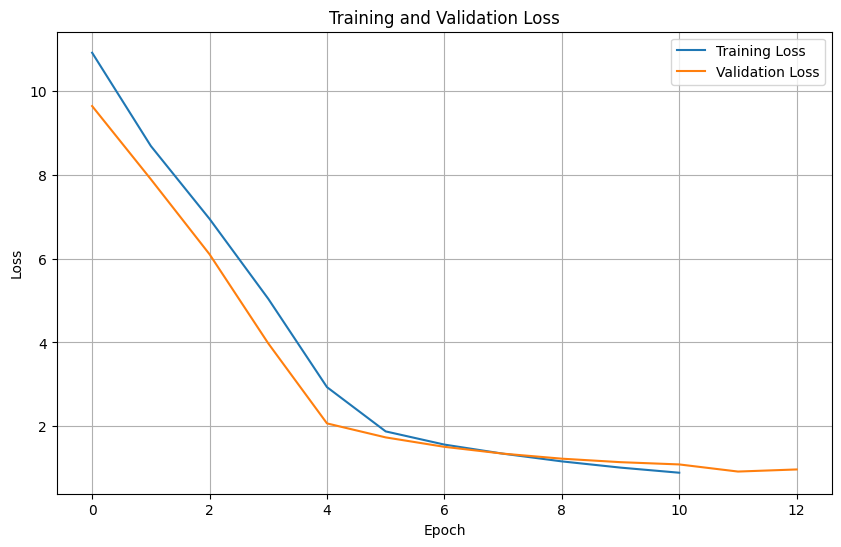

In [ ]:
import matplotlib.pyplot as plt

# Após o treinamento, os logs estão disponíveis em trainer.state.log_history
log_history = trainer.state.log_history

# Extrair perdas de treino e validação dos logs
train_losses = []
eval_losses = []
for log in log_history:
    if "loss" in log:
        train_losses.append(log["loss"])
    if "eval_loss" in log:
        eval_losses.append(log["eval_loss"])

# Gerar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


Código para verificação do último checkpoint com o modelo depois do fine-tuning

In [ ]:
import os
import re

def get_last_checkpoint(output_dir):
    # Listar todos os subdiretórios no diretório de saída
    checkpoints = [d for d in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, d))]

    # Filtrar apenas os subdiretórios de checkpoint
    checkpoint_dirs = [d for d in checkpoints if re.match(r'checkpoint-\d+', d)]

    if not checkpoint_dirs:
        return None

    # Extrair os números dos checkpoints e ordenar
    checkpoint_nums = [int(re.match(r'checkpoint-(\d+)', d).group(1)) for d in checkpoint_dirs]
    checkpoint_nums.sort()

    # O último checkpoint é o de maior número
    last_checkpoint = f"checkpoint-{checkpoint_nums[-1]}"

    return os.path.join(output_dir, last_checkpoint)

output_dir = "gemma-tunned"
last_checkpoint = get_last_checkpoint(output_dir)

if last_checkpoint:
    print(f"O último checkpoint gerado é: {last_checkpoint}")
else:
    print("Nenhum checkpoint encontrado.")


O último checkpoint gerado é: gemma-tunned/checkpoint-110


Carregamento do novo modelo:

- Carrega um novo modelo utilizando o último checkpoint com baixo uso de memória da CPU e tipo de dado float16.
- Mescla o modelo LoRA com o modelo base.
- Salva o modelo mesclado e o tokenizador em um diretório específico ("gemma-7b-tuned-merged").

In [ ]:
# Limpar a VRAM
del model  # Deleta o modelo da memória
del trainer  # Deleta o trainer da memória
import gc  # Importa o coletor de lixo
gc.collect()  # Executa a coleta de lixo
gc.collect()  # Executa a coleta de lixo novamente

# Limpar o cache da memória CUDA
torch.cuda.empty_cache()

gc.collect()  # Executa a coleta de lixo novamente

# Importa o AutoPeftModelForCausalLM da biblioteca peft
from peft import AutoPeftModelForCausalLM

# Carregar o novo modelo a partir do último checkpoint
new_model = AutoPeftModelForCausalLM.from_pretrained(
    last_checkpoint,  # Caminho para o último checkpoint
    low_cpu_mem_usage=True,  # Usa menos memória da CPU
    return_dict=True,  # Retorna um dicionário
    torch_dtype=torch.float16,  # Define o tipo de dados como float16
    device_map="auto",  # Mapeamento automático de dispositivo
)

# Mescla o modelo LoRA e o modelo base
merged_model = new_model.merge_and_unload()

# Salva o modelo mesclado
merged_model.save_pretrained("gemma-7b-tuned-merged", safe_serialization=True)
tokenizer.save_pretrained("gemma-7b-tuned-merged")  # Salva o tokenizador


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

('gemma-7b-tuned-merged/tokenizer_config.json',
 'gemma-7b-tuned-merged/special_tokens_map.json',
 'gemma-7b-tuned-merged/tokenizer.model',
 'gemma-7b-tuned-merged/added_tokens.json',
 'gemma-7b-tuned-merged/tokenizer.json')

Realização do teste do modelo após o fine-tuning:

In [ ]:
import textwrap  # Importa a biblioteca textwrap para manipulação de texto

# Define a mensagem do sistema
system = "Suponha que voce é o um assistente especialista em responder perguntas sobre a legislação da Universidade Federal do Amazonas."
# Define a pergunta a ser feita ao modelo
question = "Qual a instância responsável por estabelecer normas e regulamentos referentes ao ensino, pesquisa e extensão na Universidade Federal do Amazonas?"
# Combina a mensagem do sistema e a pergunta em um único prompt
prompt = system + question

# Tokeniza o prompt e converte para tensores, movendo para a GPU
input_ids = tokenizer(prompt, return_tensors="pt", truncation=True).input_ids.cuda()

# Gera uma resposta usando o modelo mesclado, com um máximo de 200 novos tokens e temperatura de 0.7
outputs = merged_model.generate(input_ids=input_ids,
                         max_new_tokens=200,
                         temperature=0.7)

# Decodifica os tokens gerados para texto, ignorando tokens especiais
result = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

# Remove o prompt do resultado para obter apenas a resposta
response = result[len(prompt):].strip()

# Quebra a resposta em linhas com largura máxima de 100 caracteres
wrapped_response = textwrap.fill(response, width=100)

# Imprime a resposta gerada pelo modelo ajustado
print(f"Generated response from fine-tuned model:\n\n{wrapped_response}")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Generated response from fine-tuned model:

O Conselho de Ensino, Pesquisa e Extensão (CEPE) é a instância responsável por estabelecer normas e
regulamentos referentes ao ensino, pesquisa e extensão na Universidade Federal do Amazonas. Este
órgão é constituído por membros nomeados pelo reitor da universidade e tem competência para aprovar
normas relacionadas aos cursos de graduação, pesquisa, extensão, entre outros aspectos relacionados
ao ensino superior.O Conselho de Ensino, Pesquisa e Extensão é o órgão superior responsável por
aprovar normas e regulamentos relacionados ao ensino, pesquisa e extensão na Universidade Federal do
Amazonas. Seu funcionamento é regido por normas estabelecidas pela instituição e é composto por
membros nomeados pelo reitor da universidade. Os membros do Conselho são responsáveis por aprovar
normas relacionadas aos cursos de graduação, pesquisa, extensão, entre outros aspectos relacionados
ao ensino superior.O Conselho de Ensino, Pesquisa e Extensão é uma in

Envio do novo modelo com fine tuning:

- Envia o modelo mesclado para o repositório da Hugging Face Hub
- Envia o tokenizador para o mesmo repositório da Hugging Face Hub

In [ ]:
from huggingface_hub import login  # Importa a função de login da Hugging Face Hub

# Realiza o login na Hugging Face Hub usando o token fornecido
login(token='TOKEN')

# Define o repositório do modelo na Hugging Face Hub
hf_model_repo = "lennonssss/gemma-7b-tuned"

# Envia o modelo mesclado para o repositório da Hugging Face Hub
merged_model.push_to_hub(hf_model_repo)

# Envia o tokenizador para o mesmo repositório da Hugging Face Hub
tokenizer.push_to_hub(hf_model_repo)


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/lennonssss/gemma-7b-tuned/commit/48bac96c4d6d3b526cecd3e92c33b8a17ad555d7', commit_message='Upload tokenizer', commit_description='', oid='48bac96c4d6d3b526cecd3e92c33b8a17ad555d7', pr_url=None, pr_revision=None, pr_num=None)

Realização de Testes com o Modelo após o Fine Tuning

- Definição de uma lista de perguntas sobre a legislação da Universidade Federal do Amazonas
- Crição um contexto de sistema informando que o modelo é um assistente especializado em responder perguntas sobre essa legislação.
- Para cada pergunta na lista:
 - Combina o contexto do sistema com a pergunta.
 - Tokeniza e move os tokens para a GPU.
 - Gera uma resposta usando o modelo mesclado
 - Decodifica a resposta gerada e remove o prompt inicial.
 - Formata a resposta em linhas de até 100 caracteres.
 - Imprime a resposta formatada.


In [ ]:
# Lista de perguntas
inputs_list = [
    "Qual a regra do estágio obrigatório?",
    "Qual é o objetivo do Programa de Mobilidade Estudantil da Universidade Federal do Amazonas?",
    "Quais as medidas tomadas pela Universidade Federal do Amazonas para garantir o controle do acervo bibliográfico?",
    "Quais são os documentos necessários para ocupar uma vaga em um curso de graduação na Universidade Federal do Amazonas?",
    "Quais são as diretrizes curriculares nacionais?",
    "O que o texto aborda em relação ao trote acadêmico na Universidade Federal do Amazonas?",
    "Qual é o principal objetivo da Lei de Acessibilidade para pessoas portadoras de deficiência e com mobilidade reduzida?",
    "Qual é o principal documento que estabelece as normas e diretrizes para a organização e funcionamento da Universidade Federal do Amazonas?",
    "Qual é o objetivo do programa de monitoria da Universidade Federal do Amazonas?",
    "Qual é a importância do reconhecimento de diplomas de cursos superiores pela Universidade Federal do Amazonas?"
]

system = "Suponha que voce é o um assistente especialista em responder perguntas sobre a legislação da Universidade Federal do Amazonas."

# Processar cada pergunta e imprimir a resposta
count = 0
for input_question in inputs_list:
    question = input_question
    prompt = system + question
    input_ids = tokenizer(prompt, return_tensors="pt", truncation=True).input_ids.cuda()
    outputs = merged_model.generate(input_ids=input_ids,
                         max_new_tokens=200,
                         temperature=0.7)
    result = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    # Remove the prompt from the result
    response = result[len(prompt):].strip()
    # Wrap the response into lines
    wrapped_response = textwrap.fill(response, width=100)
    count += 1
        # Print the result
    print(f"\nPergunta/Resposta {count} gerada com sucesso!\n")
    print(f"Generated response from fine-tuned model:\n\n{wrapped_response}")


Pergunta/Resposta 1 gerada com sucesso!

Generated response from fine-tuned model:

A resolução do Conselho de Ensino, Pesquisa e Extensão da UFAM estabelece que todos os alunos de
graduação devem realizar estágio obrigatório correspondendo a pelo menos 20 horas semanais, podendo
ser dividido em estágio obrigatório vinculado ao curso de graduação e estágio obrigatório vinculado
a outras entidades. O estágio obrigatório vinculado ao curso deve ser realizado em instituições
públicas ou privadas, enquanto o estágio vinculado a outras entidades deve ser realizado em empresas
privadas.O estágio obrigatório deve ser realizado durante a realização do curso de graduação e pode
ser realizado em diversas formas, como trabalho voluntário, estágio em empresas privadas ou
entidades públicas, entre outras modalidades.O estágio obrigatório deve ser registrado no portal do
aluno da UFAM, podendo ser realizado em diferentes períodos durante a duração do curso.O estágio
obrigatório deve ser aprovado po